In [1]:
# 目的: 批量準備訓練集，18顆大腦使用 [無縮放 ] 輸出存檔，並使用滑動切割成更多數據合併。
# 滑動步數改20、預處理改: 無縮放-128能被20整除、無縮放-64能被20整除
# 目的: 透過拓展的空白畫布的方式去維持原始梯度，最終依舊使用 (64,128,128) 訓練模型。
# ==========================
# 輸出: 1. 18顆各左右的3D影像 2. 滑動切割全部腦區，並輸出 3. 合併10顆大腦當作訓練集 4. 合併2顆大腦作為測試集
# 最終輸出的可以直接給模型訓練使用。

In [2]:
# 2023/05/02 詳細步驟
# 訓練集準備:
# 1. 批量準備每顆大腦的左右腦(已透過YOLO切割，並且縮放至168x168) *先輸出儲存 (檔名紀錄原始尺寸)
# 段落: 讀取每顆腦已切割的3D腦區(分別讀取成訓練集、測試集)
# 2. 先將每一個3D腦區拓展成可以匹配滑動切割的尺寸
# 3. 每組3D腦區都需準備Z軸雙向data(僅對訓練集)
# 4. 滑動切割: 20步。cube尺寸: 64,128,128 (分別對訓練集、測試集)，合併後輸出

In [3]:
# ===============正式代碼===============

In [1]:
# Step0 導入套件
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time, timeit
from patchify import patchify, unpatchify
import gc  # 引入垃圾回收模組
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import shutil
%matplotlib inline
# 資料來源資料夾
# 18顆大腦的DLG&Label 都在 DLG_18Brains_Dataset，以tif、tiff格式保存

In [2]:
# Step1_0 先設定這次要切割的大腦腦區，後續會用到"_MB.ome" 末檔案名稱
seg_target = 'FB'
seg_target_small = 'fb'
# 因為中心腦區的資料夾用 FB_EB_PB
CC_floder = 'FB_EB_PB'

In [3]:
# Step0_1
# 從 2023_正式版_暑假工讀系列專用/完成審核/AL/ 資料夾複製 以完成的tiff檔案至 DLG_18Brains_Dataset
# 已完成審核路徑 = 2023_正式版_暑假工讀系列專用/完成審核/seg_target/
FinishedPath = '2023_正式版_暑假工讀系列專用/完成審核/'+seg_target+'/'
# 讀取已完成審核路徑內的所有檔案
FinishedFiles = os.listdir(FinishedPath)
# 複製至路徑 = DLG_18Brains_Dataset/
CopyToPath = 'DLG_18Brains_Dataset/'
# 讀取CopyToPath內的所有檔案
CopyToFiles = os.listdir(CopyToPath)
# 使用迴圈將所有檔案複製至 DLG_18Brains_Dataset/ ，需確認 DLG_18Brains_Dataset/ 內的檔案是否已存在
for i in range(len(FinishedFiles)):
    if FinishedFiles[i] not in CopyToFiles:
        shutil.copyfile(FinishedPath + FinishedFiles[i], CopyToPath + FinishedFiles[i])
        print(FinishedFiles[i] + ' _本次複製完成')
    else:
        print(FinishedFiles[i] + ' _已存在')

VGlut-F-700029_FB.ome.tiff _本次複製完成
Gad1-F-400041_FB.ome.tiff _本次複製完成
Trh-F-700013_FB.ome.tiff _本次複製完成
E0585-F-200015_FB.ome.tiff _已存在
5-HT1B-M-000008_FB.ome.tiff _已存在
fru-F-500439_FB.ome.tiff _已存在
npf-M-300037_FB.ome.tiff _已存在
G0239-F-000010_FB.ome.tiff _本次複製完成
TH-F-100083_FB.ome.tiff _已存在
VGlut-F-800014_FB.ome.tiff _本次複製完成
Trh-F-200069_FB.ome.tiff _已存在
Gad1-F-400314_FB.ome.tiff _本次複製完成
Cha-F-300158_FB.ome.tiff _已存在
Gad1-F-200344_FB.ome.tiff _本次複製完成
G0239-F-000005_FB.ome.tiff _本次複製完成
Gad1-F-700093_FB.ome.tiff _本次複製完成
5HT1A-M-000005_FB.ome.tiff _已存在


DLG_shape:  (121, 1024, 1024)
Label_shape:  (121, 1024, 1024)


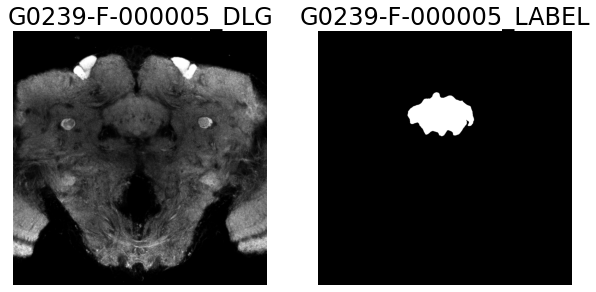

In [4]:
# Step1_1 讀取 G0239-F-000005 =============測試讀取並顯示圖片>>>可發現 G0239-F-000005 的Z軸方向是從[ 後往前 ]
# 先讀取DLG
DLG = tif.imread(r'DLG_18Brains_Dataset/G0239-F-000005.tif')
print('DLG_shape: ',DLG.shape)
# 讀取LABEL
Label = tif.imread(r'DLG_18Brains_Dataset/G0239-F-000005_'+seg_target+'.ome.tiff')
print('Label_shape: ',Label.shape)
Label[Label>0] =1
Z_num = 70
plt.figure(figsize=(10, 20))
#目標神經元三視圖
ax = plt.subplot(1, 2, 1)
plt.imshow(DLG[Z_num],cmap = 'PuBu')
ax.set_title("G0239-F-000005_DLG",fontsize=24)
plt.axis('off')
plt.gray()
#匹配神經元三視圖
ax = plt.subplot(1, 2, 2)
plt.imshow(Label[Z_num],cmap = 'PuBu')
ax.set_title("G0239-F-000005_LABEL",fontsize=24)
plt.axis('off')
plt.gray()

DLG_shape:  (122, 1024, 1024)
Label_shape:  (122, 1024, 1024)


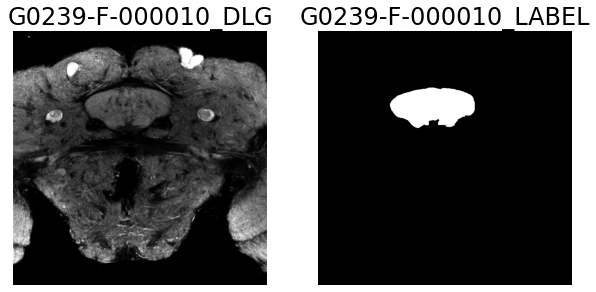

In [5]:
# Step1_2 讀取 G0239-F-000010 =============測試讀取並顯示圖片>>>可發現 G0239-F-000010 的Z軸方向是從[ 後往前 ]
import tifffile as tif
# 先讀取DLG
DLG = tif.imread(r'DLG_18Brains_Dataset/G0239-F-000010.tif')
print('DLG_shape: ',DLG.shape)
# 讀取LABEL
Label = tif.imread(r'DLG_18Brains_Dataset/G0239-F-000010_'+seg_target+'.ome.tiff')
print('Label_shape: ',Label.shape)
Label[Label>0] =1
Z_num = 70
plt.figure(figsize=(10, 20))
#目標神經元三視圖
ax = plt.subplot(1, 2, 1)
plt.imshow(DLG[Z_num],cmap = 'PuBu')
ax.set_title("G0239-F-000010_DLG",fontsize=24)
plt.axis('off')
plt.gray()
#匹配神經元三視圖
ax = plt.subplot(1, 2, 2)
plt.imshow(Label[Z_num],cmap = 'PuBu')
ax.set_title("G0239-F-000010_LABEL",fontsize=24)
plt.axis('off')
plt.gray()

In [9]:
# ===============第一步階段: 準備2D圖片給YOLO進行腦區範圍判斷===============
# ===============輸出2D投影圖(共18張) 至 waiting_for_infer資料夾===============

In [6]:
# Step2 (精簡版) 將訓練集所需的18個大腦壓成XY圖，下一步提供給YOLOv7
# 讀取 DLG_18Brains_Dataset 資料夾內的DLG tif檔案
Brain_18_tif_dir = 'DLG_18Brains_Dataset/'
# 列出所有YOLO推理輸出的圖片，只列出副檔名為png的圖片
Brain_18 = [f[:-4] for f in os.listdir(Brain_18_tif_dir) if f.endswith('.tif')]
print('原始18-Brains 總共數量: ',len(Brain_18))
# Brain_18 是18顆大腦的名稱
# 讀取 全部DLG npy的檔案 資料夾路徑: "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"
All_brain_files = os.listdir(nii_gz_src)
print('ALL-Brains 總共數量: ',len(All_brain_files))
# All_brain_files 是 28573顆大腦的檔案名稱
# 要先清空 waiting_for_infer 資料夾，才不會被先前的檔案影響
!rm -r waiting_for_infer
!mkdir waiting_for_infer
# 批量讀取npy檔案，並在迴圈中進行輸出圖片 至 output_image_path 資料夾
output_image_path = "waiting_for_infer/"

# ========================================2023/10/01新增 刪除
# 從列表中刪除 'GH146-M-400001'
# 因為人工標記中 GH146-M-400001 沒有答案
Brain_18.remove('GH146-M-400001')
print('刪除無標記的大腦後，18-Brains 總共數量: ',len(Brain_18))
for i in range(len(Brain_18)):
    print('當前處理大腦: ',Brain_18[i])
    NPY = np.load(nii_gz_src+Brain_18[i]+'.npy')
    # 需要置換兩次
    NPY = np.transpose(NPY, (1, 0, 2))
    NPY = np.transpose(NPY, (2, 0, 1))    
    # 投影成2D
    projection = np.sum(NPY, axis=0) # 取加總值
    # 將projection輸出成圖片(png)，並存至output_image_path
    plt.imsave(output_image_path+Brain_18[i]+'.png', projection, cmap='gray')
#     # ========
#     # 作圖展示原圖
#     Z_num = 70
#     plt.figure(figsize=(10, 10))
#     ax = plt.subplot(1, 1, 1)
#     plt.imshow(NPY[Z_num],cmap = 'PuBu')
#     ax.set_title(Brain_18[i],fontsize=24)
#     plt.axis('off')
#     plt.gray()
#     # ========
#     # 作圖展示投影2D圖
#     plt.figure(figsize=(10, 10))
#     ax = plt.subplot(1, 1, 1)
#     plt.imshow(projection,cmap = 'PuBu')
#     ax.set_title(Brain_18[i]+'_to_2D',fontsize=24)
#     plt.axis('off')
#     plt.gray()
#     plt.show()

原始18-Brains 總共數量:  18
ALL-Brains 總共數量:  28573
刪除無標記的大腦後，18-Brains 總共數量:  17
當前處理大腦:  Cha-F-300158
當前處理大腦:  5-HT1B-M-000008
當前處理大腦:  5HT1A-M-000005
當前處理大腦:  npf-M-300037
當前處理大腦:  Trh-F-700013
當前處理大腦:  G0239-F-000010
當前處理大腦:  VGlut-F-700029
當前處理大腦:  G0239-F-000005
當前處理大腦:  Gad1-F-200344
當前處理大腦:  E0585-F-200015
當前處理大腦:  Gad1-F-700093
當前處理大腦:  Trh-F-200069
當前處理大腦:  VGlut-F-800014
當前處理大腦:  Gad1-F-400314
當前處理大腦:  fru-F-500439
當前處理大腦:  TH-F-100083
當前處理大腦:  Gad1-F-400041


# 舊版 Step2 目的: 將18顆大腦投影成XY面
# Step2 將訓練集所需的大腦壓成XY圖，因為需要推理MB的邊界框(YOLOv7) =================已經執行過，可以無需再執行一次!
# 只用18顆大腦，不要使用標準腦
# 讀取所有DLG npy的檔案名稱
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"
src_files = os.listdir(nii_gz_src)
# 批量將18個大腦都投影成18張2D圖
Brain_18 = ['5HT1A-M-000005','5-HT1B-M-000008','Cha-F-300158','E0585-F-200015','fru-F-500439','G0239-F-000005','G0239-F-000010','Gad1-F-200344','Gad1-F-400041','Gad1-F-400314','Gad1-F-700093','GH146-M-400001','npf-M-300037','TH-F-100083','Trh-F-200069','Trh-F-700013','VGlut-F-700029','VGlut-F-800014']
#開始進行將低解析度三維矩陣3D圖形轉2D圖形（二維矩陣）(XY截面)
import time, timeit
def _test_faster_3D_to_2D(NumOfFiles,target_array):
    New_one_Dimension_List = target_array
    New_X=New_one_Dimension_List[NumOfFiles].shape[0]
    New_Y=New_one_Dimension_List[NumOfFiles].shape[1]
    New_Z=New_one_Dimension_List[NumOfFiles].shape[2]
    for ii in range(1):
        #將標準化後的一維矩陣轉換回三維矩陣
        xyz_mx = New_one_Dimension_List[NumOfFiles].reshape(New_X, New_Y, New_Z)
        #平面化成2D
        proj_face_xy = np.zeros((New_X, New_Y), dtype=int)
        for i in range(New_X):
            for j in range(New_Y):
              proj_face_xy[i,j] = np.sum(xyz_mx[i,j,:])
        proj_face_xy = proj_face_xy.reshape(1,New_X,New_Y)

    return proj_face_xy
# 要先清空 waiting_for_infer 資料夾，才不會被先前的檔案影響
!rm -r waiting_for_infer
!mkdir waiting_for_infer

# 將18個DLG讀取進來並且拼接
tStart = time.time()  # 計時開始
New_one_Dimension_List = []
for i in range(len(Brain_18)):
    New_one_Dimension_List.append(np.load(nii_gz_src+Brain_18[i]+'.npy'))
    # 因為腦科下載下來的立體圖需要旋轉，所以需要將 XY互換
    New_one_Dimension_List[i]= np.transpose(New_one_Dimension_List[i], (1,0,2))
tEnd = time.time()  
print("It cost %f sec" % (tEnd - tStart))

# 開始批量輸出2D圖片
for i in range(len(Brain_18)):
    
    tStart = time.time()  # 計時開始
    # 這裡 輸入編號 0~17
    Two_Dimension_List = _test_faster_3D_to_2D(i,New_one_Dimension_List)
    tEnd = time.time()  
    print("It cost %f sec" % (tEnd - tStart))  
    %matplotlib inline
    # 查閱Z軸層數
    plt.figure(figsize=(5, 5))
    #目標神經元三視圖
    plt.imshow(Two_Dimension_List[0],cmap = 'PuBu')
    plt.axis('off')
    plt.gray()
    # 輸出目標腦DLG圖片至 waiting_for_infer (等待YOLO進行偵測)
    Two_Dimension_List = Two_Dimension_List/np.max(Two_Dimension_List)*255
    im = Image.fromarray(Two_Dimension_List[0].astype('uint8'))# 要將float32 改成uint8
    im.save('waiting_for_infer/'+Brain_18[i]+'.png')

In [7]:
# Step3 使用YOLOv7 對 XY view進行預測MB特徵框 ===================此步驟是執行YOLO推理腦區範圍(未來可以直接更換腦區種類權重)
# 輸出的推理結果在: CC_floder+'_inference/detect' 資料夾
DLG_src_files = os.listdir('waiting_for_infer')
print('等待推理的圖片數量: ',len(DLG_src_files))
# 原本呼叫終端機方法改成 os.system
#!rm -r al_inference/detect
os.system('rm -r '+CC_floder+'_inference/detect')
# GT顏色 = #FFC000 = (0, 192, 255) 問GPT: #FFC000 對應BGR表示法[detect.py 預設是GT的顏色]
# MB顏色 = #00B0F0 = (240, 176, 0) 問GPT: #00B0F0 對應BGR表示法
# AL顏色 = #FF0000 = (0, 0, 255)   問GPT: #FF0000 對應BGR表示法
# 未來若要偵測其他腦區需要換 weights =========== 需要手動改 FB_EB_PB_inference ===========
!python detect.py --color 0 0 255 --weights ./FB_EB_PB_trained/train/exp/weights/best.pt --source waiting_for_infer --img-size 640 --save-txt --project FB_EB_PB_inference/detect

等待推理的圖片數量:  17
opt==== Namespace(agnostic_nms=False, augment=False, classes=None, color=[0, 0, 255], conf_thres=0.5, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='FB_EB_PB_inference/detect', save_conf=False, save_txt=True, source='waiting_for_infer', update=False, view_img=False, weights=['./FB_EB_PB_trained/train/exp/weights/best.pt'])
custom_color:  [0, 0, 255]
YOLOR 🚀 2022-11-10 torch 2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536.1875MB)
                                     CUDA:1 (NVIDIA A100-SXM4-40GB, 39538.25MB)

Fusing layers... 
IDetect.fuse
/root/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 362 layers, 70782444 parameters, 0 gradients, 188.

In [8]:
# ========================以上完成18顆腦的2D投影+推理MB邊界============================
# ========================未來只跑下方，切割需要訓練的範圍============================

In [9]:
# ===============第一步階段: 使用YOLO推理結果切割腦區範圍===============
# ===============批量切割腦區範圍: 需要縮放至168x168，並拓展成可滑動切割的尺寸，輸出儲存npy(需紀錄原始切割後尺寸)===============

DLG_shape:  (121, 1024, 1024)


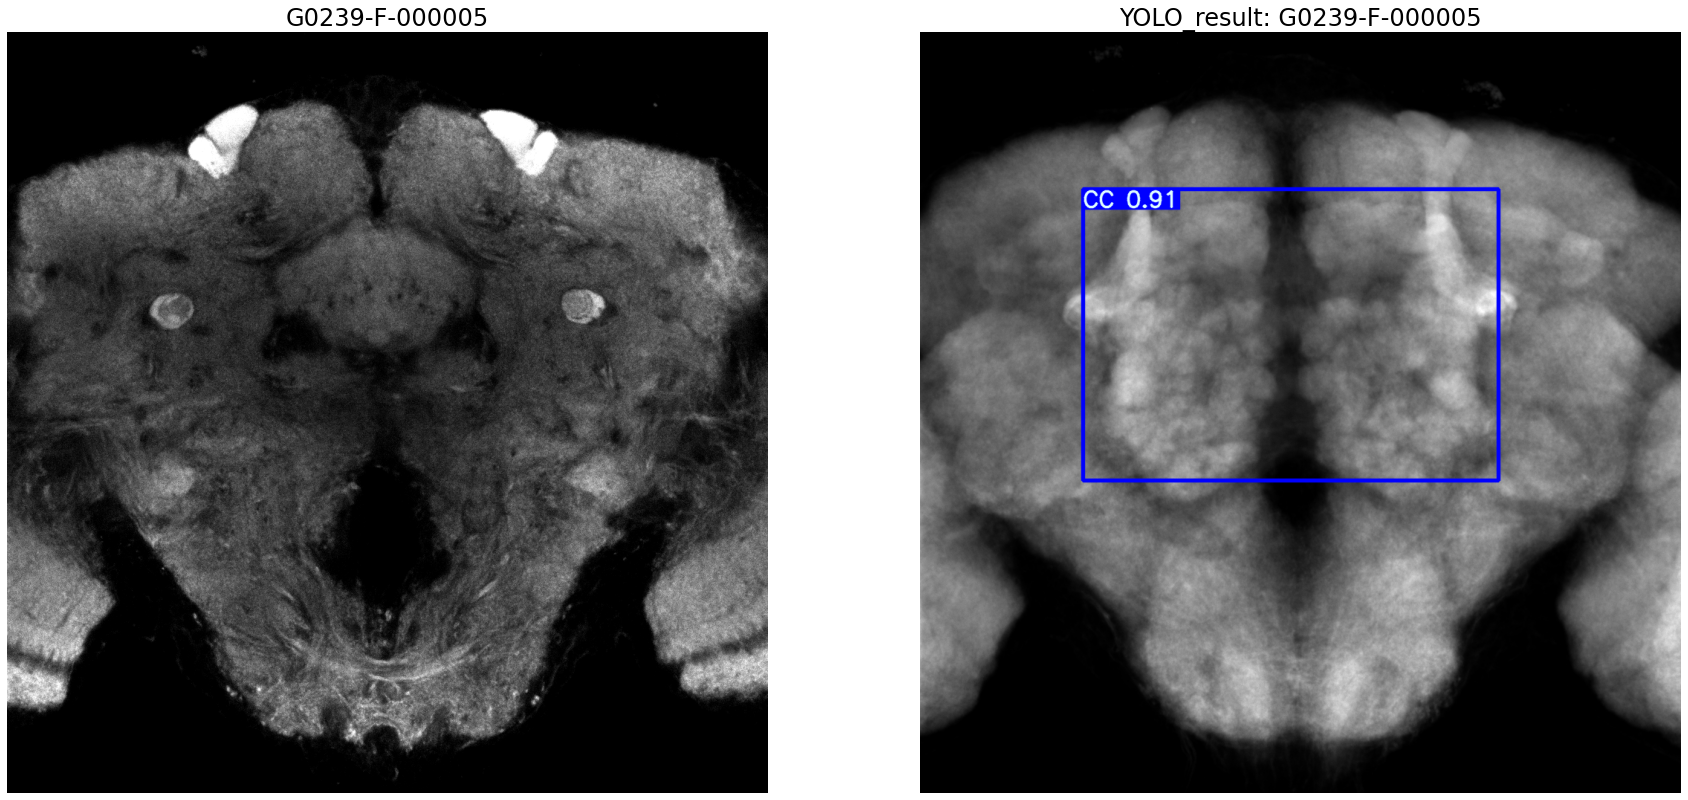

In [10]:
# Step4 準備目標腦的DLG npy檔案，準備切割出特徵框的範圍 ===========測試查看 G0239-F-000005 DLG & 推理結果
# 批量將18個大腦都投影成18張2D圖
Brain_18 = ['5HT1A-M-000005','5-HT1B-M-000008','Cha-F-300158','E0585-F-200015','fru-F-500439','G0239-F-000005','G0239-F-000010','Gad1-F-200344','Gad1-F-400041','Gad1-F-400314','Gad1-F-700093','GH146-M-400001','npf-M-300037','TH-F-100083','Trh-F-200069','Trh-F-700013','VGlut-F-700029','VGlut-F-800014']
DLG = tif.imread(r'DLG_18Brains_Dataset/G0239-F-000005.tif')
print('DLG_shape: ',DLG.shape)
# 同時顯示 目標腦的DLG 某一層，以及 推理結果的圖片(查看MB腦區特徵框是否正確)
img = cv2.imread(CC_floder+'_inference/detect/exp/'+Brain_18[5]+'.png')
Z_num = 70
plt.figure(figsize=(30, 60))
#目標神經元三視圖
ax = plt.subplot(1, 2, 1)
plt.imshow(DLG[Z_num],cmap = 'PuBu')
ax.set_title("G0239-F-000005",fontsize=24)
plt.axis('off')
plt.gray()
# 這裡Z軸順序和標準腦相反(應該不影響)
ax = plt.subplot(1, 2, 2)
plt.imshow(img,cmap = 'PuBu')
ax.set_title("YOLO_result: "+Brain_18[5],fontsize=24)
plt.axis('off')
plt.gray()

DLG_shape:  (122, 1024, 1024)


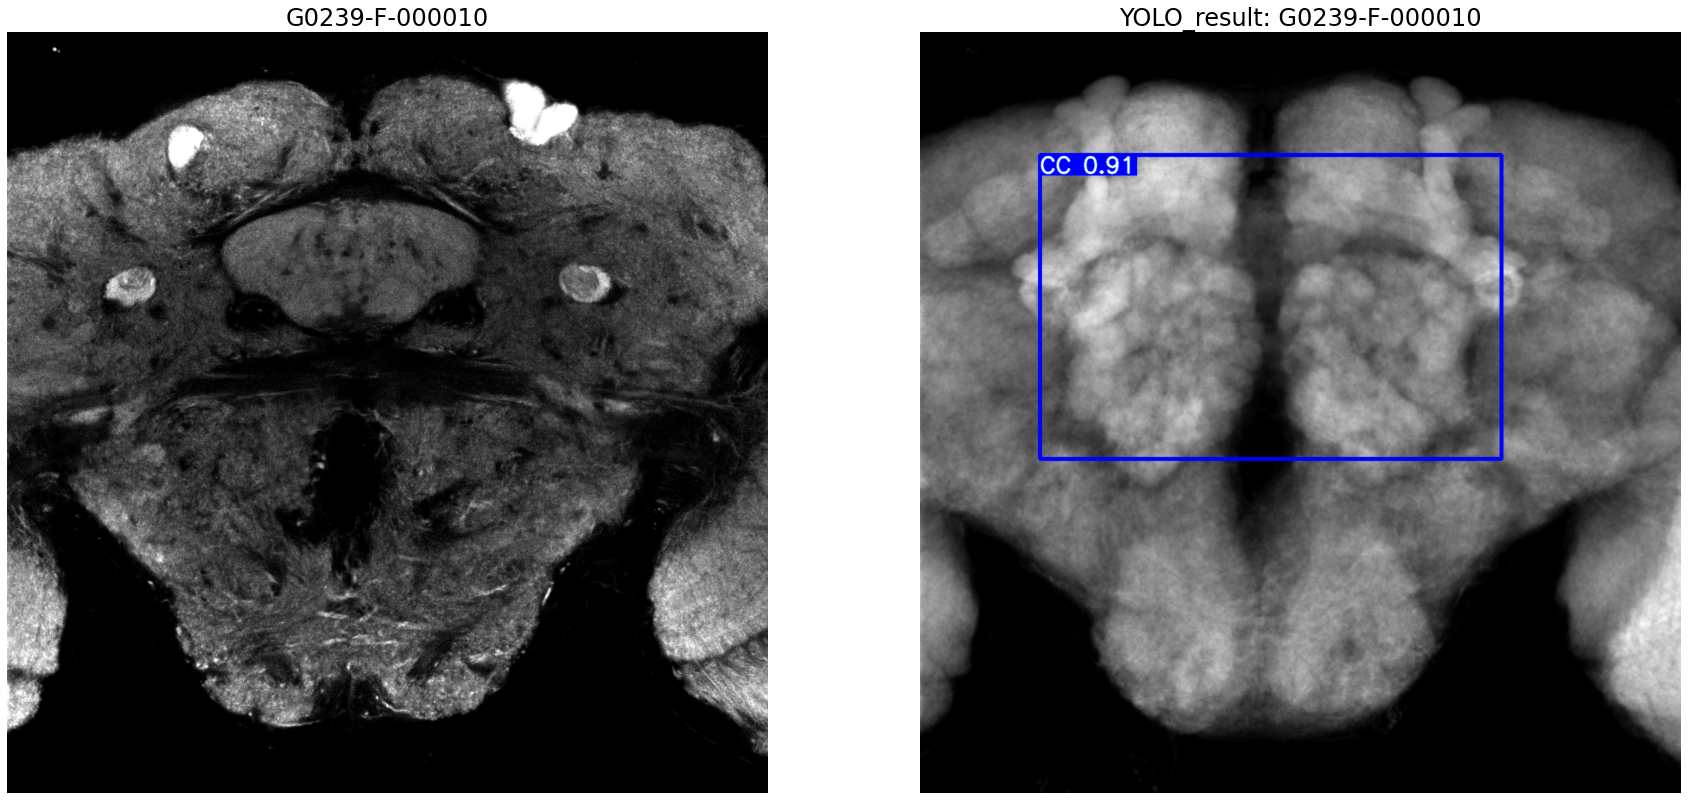

In [11]:
# Step4 準備目標腦的DLG npy檔案，準備切割出特徵框的範圍 ===========測試查看 G0239-F-000010 DLG & 推理結果
DLG = tif.imread(r'DLG_18Brains_Dataset/G0239-F-000010.tif')
print('DLG_shape: ',DLG.shape)
# 同時顯示 目標腦的DLG 某一層，以及 推理結果的圖片(查看MB腦區特徵框是否正確)
img = cv2.imread(CC_floder+'_inference/detect/exp/'+Brain_18[6]+'.png')
Z_num = 70
plt.figure(figsize=(30, 60))
#目標神經元三視圖
ax = plt.subplot(1, 2, 1)
plt.imshow(DLG[Z_num],cmap = 'PuBu')
ax.set_title("G0239-F-000010",fontsize=24)
plt.axis('off')
plt.gray()
# 這裡Z軸順序和標準腦相反(應該不影響)
ax = plt.subplot(1, 2, 2)
plt.imshow(img,cmap = 'PuBu')
ax.set_title("YOLO_result: "+Brain_18[6],fontsize=24)
plt.axis('off')
plt.gray()

In [12]:
# ===============批量切割腦區範圍: 需要縮放至168x168，並拓展成可滑動切割的尺寸，輸出儲存npy(需紀錄原始切割後尺寸)===============
# 讀取 DLG_18Brains_Dataset 資料夾內檔案名稱有 _+seg_target+.ome.tiff 的檔案名稱，製作成列表(代表目前已經有Label的大腦名稱)
DLG_src_files = os.listdir('DLG_18Brains_Dataset')
LABEL_src_files = [i for i in DLG_src_files if '_'+seg_target+'.ome.tiff' in i]
print('已經有Label的大腦數量: ',len(LABEL_src_files))
# 將LABEL_src_files 的檔案名稱去除 _+seg_target+.ome.tiff 改成.tif後，存入DLG_src_files
DLG_src_files = [i.replace('_'+seg_target+'.ome.tiff','.tif') for i in LABEL_src_files]
# 批量處理已經有LABEL的大腦: 目前9顆。 DLG_src_files 是DLG tif檔案名稱，LABEL_src_files 是對應的LABEL tiff檔案名稱。
# 已經將DLG LABEL的名稱都準備好，下一步批量處理切割範圍

已經有Label的大腦數量:  17


In [13]:
# Step5 批量讀取 DLG_18Brains_Dataset 資料夾中的18顆大腦DLG & LABEL，並切割後縮放，再加以拓展成滑動視窗所需的尺寸
# DLG_src_files = 是DLG列表
# LABEL_src_files = 是LABEL列表
# 開始批量處理
!rm -r 2023_18_Brain_3DUNET_DataSet
!mkdir 2023_18_Brain_3DUNET_DataSet
for num in range(len(DLG_src_files)):
    print(num)
    # 設定批次的大腦名稱: target_name
    target_name = DLG_src_files[num][:-4]
    print(target_name)
    # 讀取 DLG + LABEL
    DLG = tif.imread(r'DLG_18Brains_Dataset/'+target_name+'.tif')
    # 因為後續要切割DLG範圍需要用到 WholeBrain_DLG_Amira
    WholeBrain_DLG_Amira = DLG.copy()
    print('DLG_shape: ',DLG.shape)
    # 讀取LABEL
    Label = tif.imread(r'DLG_18Brains_Dataset/'+target_name+'_'+seg_target+'.ome.tiff')
    Label[Label>0] =1
    Label = Label.astype('uint8')
    WholeBrain_LABEL_Amira = Label.copy()
    print('Label_shape: ',Label.shape)
    # =============
    txt_path  = os.path.join(CC_floder+'_inference/detect/exp/labels','%s.txt'%(target_name))  #本次检测结果txt路径
    source_file = open(txt_path)
    image = cv2.imread('waiting_for_infer/'+target_name+'.png')
    img = cv2.imread(CC_floder+'_inference/detect/exp/'+target_name+'.png')
    try:
        height, width, channels = image.shape
    except:
        print('no shape info.')
    # 因為會不只一組 x1 x2 y1 y2
    x1=[]
    x2=[]
    y1=[]
    y2=[]
    for line in source_file: #例遍 txt文件得每一行
        staff = line.split() #对每行内容 通过以空格为分隔符对字符串进行切片
        class_idx = int(staff[0])

        x_center, y_center, w, h = float(staff[1])*width, float(staff[2])*height, float(staff[3])*width, float(staff[4])*height
        x1.append(round(x_center-w/2))
        y1.append(round(y_center-h/2))
        x2.append(round(x_center+w/2))
        y2.append(round(y_center+h/2) )
    # # 目前是單純做圖檢查!!!!
    # # 作圖展示txt讀取出得特徵框是否正確(右腦)
    # X_start = x1[0]
    # Y_start = y1[0]
    # X_end = x2[0]
    # Y_end = y2[0]
    # X_length = X_end-X_start
    # Y_length = Y_end-Y_start
    # # 先繪製出需要切割出的範圍
    # # 確認單張用
    # #img_gray = WholeBrain_DLG_Amira[70]# 這是看某一切片
    # img_gray = img
    # fig, ax = plt.subplots(figsize=(10,10))
    # #plt.axis(False)
    # ax.imshow(img_gray,cmap='gray')
    # for i in range(1):
    #   # X第一條線（上方橫線）
    #   x_1 = np.arange(X_start , X_start+X_length)
    #   ax.plot(x_1, np.full_like(x_1,Y_start) , linewidth=2, alpha=1,color='y')

    #   # X第二條線(下方橫線)
    #   ax.plot(x_1, np.full_like(x_1,Y_start+Y_length) , linewidth=2, alpha=1,color='y')

    #   # Y第一條線
    #   y_1 = np.arange(Y_start, Y_start+Y_length)
    #   ax.plot(np.full_like(y_1,X_start), y_1 , linewidth=2, alpha=1,color='y')

    #   ax.plot(np.full_like(y_1,X_start+X_length), y_1 , linewidth=2, alpha=1,color='y')
    # plt.axis('off')
    # plt.show()
    # X_start = x1[1]
    # Y_start = y1[1]
    # X_end = x2[1]
    # Y_end = y2[1]
    # X_length = X_end-X_start
    # Y_length = Y_end-Y_start
    # # 先繪製出需要切割出的範圍
    # # 確認單張用
    # #img_gray = WholeBrain_Label_0_1_2[47]# 這是看某一切片
    # img_gray = img
    # fig, ax = plt.subplots(figsize=(10,10))
    # #plt.axis(False)
    # ax.imshow(img_gray,cmap='gray')
    # for i in range(1):
    #   # X第一條線（上方橫線）
    #   x_1 = np.arange(X_start , X_start+X_length)
    #   ax.plot(x_1, np.full_like(x_1,Y_start) , linewidth=2, alpha=1,color='y')

    #   # X第二條線(下方橫線)
    #   ax.plot(x_1, np.full_like(x_1,Y_start+Y_length) , linewidth=2, alpha=1,color='y')

    #   # Y第一條線
    #   y_1 = np.arange(Y_start, Y_start+Y_length)
    #   ax.plot(np.full_like(y_1,X_start), y_1 , linewidth=2, alpha=1,color='y')

    #   ax.plot(np.full_like(y_1,X_start+X_length), y_1 , linewidth=2, alpha=1,color='y')
    # plt.axis('off')
    # plt.show()
    # Step_of_slide = 20 # 滑動步數
    Step_of_slide = 20 # 滑動步數
    # 切割後需要新增拓展Z軸的代碼
    # ======================================此段是處理DLG部分================================
    # 先評估有多少特徵框 e.g 0~2
    num_of_yolo_box = len(x1)
    # 判斷是否有偵測到MB腦區，若無直接結束
    if num_of_yolo_box == 0:
        print('此大腦沒有MB腦區')
    else:
        # 確定有MB腦區，才進行下一步
        #============
        # 1個MB和2個MB的大腦使用不同流程
        # 先寫1個MB的版本
        if num_of_yolo_box ==1:
            print('僅有一個腦區')
            # No_1_BOX 是要儲存切割出來的3D 影像(完成縮放)
            No_1_BOX = []
            X_start = x1[0]
            Y_start = y1[0]
            X_end = x2[0]
            Y_end = y2[0]
            X_length = X_end-X_start
            Y_length = Y_end-Y_start
            # 已經提取出特徵框的長寬，需要判別是否已經是正方型，若非，則拓展某一邊長
            # 如果X邊大於Y邊，則對Y邊拓展
            if X_length-Y_length>0:
                print('X邊大於Y邊')
                X_start = x1[0]
                Y_start = y1[0]-((X_length-Y_length)//2)
                X_end = x2[0]
                Y_end = y2[0]+(X_length-Y_length-(X_length-Y_length)//2)
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # 如果Y邊大於X邊，則對Y邊拓展
            if Y_length-X_length>0:
                print('Y邊大於X邊')
                X_start = x1[0]-((Y_length-X_length)//2)
                Y_start = y1[0]
                X_end = x2[0]+(Y_length-X_length-(Y_length-X_length)//2)
                Y_end = y2[0]
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # ====以上完成一個腦區的拓展成正方形，下一步: 紀錄下目前的長寬位置(最後要放回DLG用)，並開始縮放至 168x168
            # log(紀錄)切割出來的座標(未來要放回)
            X_start_of_No1 = X_start
            Y_start_of_No1 = Y_start
            X_end_of_No1 = X_end
            Y_end_of_No1 = Y_end
            # 紀錄縮放前的原始長寬
            X_length_of_No1 = X_length
            Y_length_of_No1 = Y_length
            # 開始切割
            WholeBrain_DLG_of_No1 = []
            for i in range(len(WholeBrain_DLG_Amira)):
                WholeBrain_DLG_of_No1.append(WholeBrain_DLG_Amira[i,Y_start:Y_end,X_start:X_end])
            WholeBrain_DLG_of_No1 = np.array(WholeBrain_DLG_of_No1)
            print('切割後之No1_DLG: ',WholeBrain_DLG_of_No1.shape)
            # 開始縮放
            # 縮小或放大用不同的方法效果更好
            # 如果需要縮小 採用 INTER_AREA 
            if X_length_of_No1>168:
                for i in range(len(WholeBrain_DLG_of_No1)):
                    No_1_BOX.append(cv2.resize(WholeBrain_DLG_of_No1[i], (168, 168), interpolation=cv2.INTER_AREA))
                No_1_BOX = np.array(No_1_BOX)
                print('縮小後之No1_DLG: ',No_1_BOX.shape)
            # 如果需要放大 採用 INTER_CUBIC 
            if X_length_of_No1<168:
                for i in range(len(WholeBrain_DLG_of_No1)):
                    No_1_BOX.append(cv2.resize(WholeBrain_DLG_of_No1[i], (168, 168), interpolation=cv2.INTER_CUBIC))
                No_1_BOX = np.array(No_1_BOX)
                print('放大後之No1_DLG: ',No_1_BOX.shape)
            # 將唯一的縮放好的特徵框輸出
            # For_FCN_Inference = No_1_BOX
            # 紀錄切割後的原始尺寸: WholeBrain_DLG_of_No1.shape
            # 開始拓展切割後+縮放後的Z軸:
            # 當前處理腦區變數: No_1_BOX
            Current_Brain = No_1_BOX
            # 為了記錄總共添加幾層
            Num_layers_need_del = 0
            for i in range(100):
                # 判斷此腦區Z軸是否<64
                if len(Current_Brain)<64:
                    Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                    # 添加一層就對 Num_layers_need_del_No1 +1
                    Num_layers_need_del = Num_layers_need_del+1
                elif len(Current_Brain)==64:
                    break
                elif len(Current_Brain)>64:
                    if (len(Current_Brain)-64)%Step_of_slide ==0:
                        break
                    else:
                        Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                        # 添加一層就對 Num_layers_need_del_No1 +1
                        Num_layers_need_del = Num_layers_need_del+1
            print('總共額外添加層數: ',Num_layers_need_del)
            print('拓展前此腦區層數: ',No_1_BOX.shape)
            print('拓展後此腦區層數: ',Current_Brain.shape)
            No_1_BOX = Current_Brain
            # 輸出此腦DLG 到 2023_18_Brain_3DUNET_DataSet
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_DLG',No_1_BOX)
            # =============2023/10/10 新增輸出原始解析度的DLG & LABEL=============
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_original_DLG',WholeBrain_DLG_of_No1)

    
    # =============================================================
        # 1個MB和2個MB的大腦使用不同流程
        # 寫2個MB的版本
        if num_of_yolo_box ==2:
            print('有二個腦區')
            # =========先處理第一個腦區
            # No_1_BOX 是要儲存切割出來的3D 影像(完成縮放)
            print('=========')
            print('處理第一個腦區')
            No_1_BOX = []
            X_start = x1[0]
            Y_start = y1[0]
            X_end = x2[0]
            Y_end = y2[0]
            X_length = X_end-X_start
            Y_length = Y_end-Y_start
            # 已經提取出特徵框的長寬，需要判別是否已經是正方型，若非，則拓展某一邊長
            # 如果X邊大於Y邊，則對Y邊拓展
            if X_length-Y_length>0:
                print('X邊大於Y邊')
                X_start = x1[0]
                Y_start = y1[0]-((X_length-Y_length)//2)
                X_end = x2[0]
                Y_end = y2[0]+(X_length-Y_length-(X_length-Y_length)//2)
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # 如果Y邊大於X邊，則對Y邊拓展
            if Y_length-X_length>0:
                print('Y邊大於X邊')
                X_start = x1[0]-((Y_length-X_length)//2)
                Y_start = y1[0]
                X_end = x2[0]+(Y_length-X_length-(Y_length-X_length)//2)
                Y_end = y2[0]
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # ====以上完成一個腦區的拓展成正方形，下一步: 紀錄下目前的長寬位置(最後要放回DLG用)，並開始縮放至 168x168
            # log(紀錄)切割出來的座標(未來要放回)
            X_start_of_No1 = X_start
            Y_start_of_No1 = Y_start
            X_end_of_No1 = X_end
            Y_end_of_No1 = Y_end
            # 紀錄縮放前的原始長寬
            X_length_of_No1 = X_length
            Y_length_of_No1 = Y_length
            # 開始切割
            WholeBrain_DLG_of_No1 = []
            for i in range(len(WholeBrain_DLG_Amira)):
                WholeBrain_DLG_of_No1.append(WholeBrain_DLG_Amira[i,Y_start:Y_end,X_start:X_end])
            WholeBrain_DLG_of_No1 = np.array(WholeBrain_DLG_of_No1)
            print('切割後之No1_DLG: ',WholeBrain_DLG_of_No1.shape)
            # 開始縮放
            # 縮小或放大用不同的方法效果更好
            # 如果需要縮小 採用 INTER_AREA 
            if X_length_of_No1>168:
                for i in range(len(WholeBrain_DLG_of_No1)):
                    No_1_BOX.append(cv2.resize(WholeBrain_DLG_of_No1[i], (168, 168), interpolation=cv2.INTER_AREA))
                No_1_BOX = np.array(No_1_BOX)
                print('縮小後之No1_DLG: ',No_1_BOX.shape)
            # 如果需要放大 採用 INTER_CUBIC 
            if X_length_of_No1<168:
                for i in range(len(WholeBrain_DLG_of_No1)):
                    No_1_BOX.append(cv2.resize(WholeBrain_DLG_of_No1[i], (168, 168), interpolation=cv2.INTER_CUBIC))
                No_1_BOX = np.array(No_1_BOX)
                print('放大後之No1_DLG: ',No_1_BOX.shape)
            # 紀錄切割後的原始尺寸: WholeBrain_DLG_of_No1.shape
            # 開始拓展切割後+縮放後的Z軸:
            # 當前處理腦區變數: No_1_BOX
            Current_Brain = No_1_BOX
            # 為了記錄總共添加幾層
            Num_layers_need_del = 0
            for i in range(100):
                # 判斷此腦區Z軸是否<64
                if len(Current_Brain)<64:
                    Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                    # 添加一層就對 Num_layers_need_del_No1 +1
                    Num_layers_need_del = Num_layers_need_del+1
                elif len(Current_Brain)==64:
                    break
                elif len(Current_Brain)>64:
                    if (len(Current_Brain)-64)%Step_of_slide ==0:
                        break
                    else:
                        Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                        # 添加一層就對 Num_layers_need_del_No1 +1
                        Num_layers_need_del = Num_layers_need_del+1
            print('總共額外添加層數: ',Num_layers_need_del)
            print('拓展前此腦區層數: ',No_1_BOX.shape)
            print('拓展後此腦區層數: ',Current_Brain.shape)
            No_1_BOX = Current_Brain
    # =======================================
            # =========處理第2個腦區
            # No_2_BOX 是要儲存切割出來的3D 影像(完成縮放)
            print('=========')
            print('處理第二個腦區')
            No_2_BOX = []
            X_start = x1[1]
            Y_start = y1[1]
            X_end = x2[1]
            Y_end = y2[1]
            X_length = X_end-X_start
            Y_length = Y_end-Y_start
            # 已經提取出特徵框的長寬，需要判別是否已經是正方型，若非，則拓展某一邊長
            # 如果X邊大於Y邊，則對Y邊拓展
            if X_length-Y_length>0:
                print('X邊大於Y邊')
                X_start = x1[1]
                Y_start = y1[1]-((X_length-Y_length)//2)
                X_end = x2[1]
                Y_end = y2[1]+(X_length-Y_length-(X_length-Y_length)//2)
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # 如果Y邊大於X邊，則對Y邊拓展
            if Y_length-X_length>0:
                print('Y邊大於X邊')
                X_start = x1[1]-((Y_length-X_length)//2)
                Y_start = y1[1]
                X_end = x2[1]+(Y_length-X_length-(Y_length-X_length)//2)
                Y_end = y2[1]
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # ====以上完成一個腦區的拓展成正方形，下一步: 紀錄下目前的長寬位置(最後要放回DLG用)，並開始縮放至 168x168
            # log(紀錄)切割出來的座標(未來要放回)
            X_start_of_No2 = X_start
            Y_start_of_No2 = Y_start
            X_end_of_No2 = X_end
            Y_end_of_No2 = Y_end
            # 紀錄縮放前的原始長寬
            X_length_of_No2 = X_length
            Y_length_of_No2 = Y_length
            # 開始切割
            WholeBrain_DLG_of_No2 = []
            for i in range(len(WholeBrain_DLG_Amira)):
                WholeBrain_DLG_of_No2.append(WholeBrain_DLG_Amira[i,Y_start:Y_end,X_start:X_end])
            WholeBrain_DLG_of_No2 = np.array(WholeBrain_DLG_of_No2)
            print('切割後之No2_DLG: ',WholeBrain_DLG_of_No2.shape)
            # 開始縮放
            # 縮小或放大用不同的方法效果更好
            # 如果需要縮小 採用 INTER_AREA 
            if X_length_of_No1>168:
                for i in range(len(WholeBrain_DLG_of_No2)):
                    No_2_BOX.append(cv2.resize(WholeBrain_DLG_of_No2[i], (168, 168), interpolation=cv2.INTER_AREA))
                No_2_BOX = np.array(No_2_BOX)
                print('縮小後之No2_DLG: ',No_2_BOX.shape)
            # 如果需要放大 採用 INTER_CUBIC 
            if X_length_of_No1<168:
                for i in range(len(WholeBrain_DLG_of_No2)):
                    No_2_BOX.append(cv2.resize(WholeBrain_DLG_of_No2[i], (168, 168), interpolation=cv2.INTER_CUBIC))
                No_2_BOX = np.array(No_2_BOX)
                print('放大後之No2_DLG: ',No_2_BOX.shape)
            # 將唯一的縮放好的特徵框輸出
            # For_FCN_Inference = np.append(No_1_BOX, No_2_BOX, axis=0)
            # 紀錄切割後的原始尺寸: WholeBrain_DLG_of_No1.shape
            # 開始拓展切割後+縮放後的Z軸:
            # 當前處理腦區變數: No_2_BOX
            Current_Brain = No_2_BOX
            # 為了記錄總共添加幾層
            Num_layers_need_del = 0
            for i in range(100):
                # 判斷此腦區Z軸是否<64
                if len(Current_Brain)<64:
                    Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                    # 添加一層就對 Num_layers_need_del_No1 +1
                    Num_layers_need_del = Num_layers_need_del+1
                elif len(Current_Brain)==64:
                    break
                elif len(Current_Brain)>64:
                    if (len(Current_Brain)-64)%Step_of_slide ==0:
                        break
                    else:
                        Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                        # 添加一層就對 Num_layers_need_del_No1 +1
                        Num_layers_need_del = Num_layers_need_del+1
            print('總共額外添加層數: ',Num_layers_need_del)
            print('拓展前此腦區層數: ',No_2_BOX.shape)
            print('拓展後此腦區層數: ',Current_Brain.shape)
            No_2_BOX = Current_Brain
            # 輸出此腦DLG 到 2023_18_Brain_3DUNET_DataSet
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_DLG',No_1_BOX)
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_2_DLG',No_2_BOX)
            # =============2023/10/10 新增輸出原始解析度的DLG & LABEL=============
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_original_DLG',WholeBrain_DLG_of_No1)
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_2_original_DLG',WholeBrain_DLG_of_No2)

    
    # 以上已經完成切割腦區特徵框，並且縮放置FCN所需大小
    # For_training_DLG = For_FCN_Inference.copy()
    # print('切割完成_準備訓練的訓練集DLG形狀: ',For_training_DLG.shape)
    
    # ======================================此段是處理LABEL部分================================
    # 先評估有多少特徵框 e.g 0~2
    num_of_yolo_box = len(x1)
    # 判斷是否有偵測到MB腦區，若無直接結束
    if num_of_yolo_box == 0:
        print('此大腦沒有MB腦區')
    else:
        # 確定有MB腦區，才進行下一步
        #============
        # 1個MB和2個MB的大腦使用不同流程
        # 先寫1個MB的版本
        if num_of_yolo_box ==1:
            print('僅有一個腦區')
            # No_1_BOX 是要儲存切割出來的3D 影像(完成縮放)
            No_1_BOX = []
            X_start = x1[0]
            Y_start = y1[0]
            X_end = x2[0]
            Y_end = y2[0]
            X_length = X_end-X_start
            Y_length = Y_end-Y_start
            # 已經提取出特徵框的長寬，需要判別是否已經是正方型，若非，則拓展某一邊長
            # 如果X邊大於Y邊，則對Y邊拓展
            if X_length-Y_length>0:
                print('X邊大於Y邊')
                X_start = x1[0]
                Y_start = y1[0]-((X_length-Y_length)//2)
                X_end = x2[0]
                Y_end = y2[0]+(X_length-Y_length-(X_length-Y_length)//2)
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # 如果Y邊大於X邊，則對Y邊拓展
            if Y_length-X_length>0:
                print('Y邊大於X邊')
                X_start = x1[0]-((Y_length-X_length)//2)
                Y_start = y1[0]
                X_end = x2[0]+(Y_length-X_length-(Y_length-X_length)//2)
                Y_end = y2[0]
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # ====以上完成一個腦區的拓展成正方形，下一步: 紀錄下目前的長寬位置(最後要放回DLG用)，並開始縮放至 168x168
            # log(紀錄)切割出來的座標(未來要放回)
            X_start_of_No1 = X_start
            Y_start_of_No1 = Y_start
            X_end_of_No1 = X_end
            Y_end_of_No1 = Y_end
            # 紀錄縮放前的原始長寬
            X_length_of_No1 = X_length
            Y_length_of_No1 = Y_length
            # 開始切割
            WholeBrain_DLG_of_No1 = []
            for i in range(len(WholeBrain_DLG_Amira)):
                WholeBrain_DLG_of_No1.append(WholeBrain_LABEL_Amira[i,Y_start:Y_end,X_start:X_end])
            WholeBrain_DLG_of_No1 = np.array(WholeBrain_DLG_of_No1)
            print('切割後之No1_DLG: ',WholeBrain_DLG_of_No1.shape)
            # 開始縮放
            # 縮小或放大用不同的方法效果更好
            # 如果需要縮小 採用 INTER_AREA 
            if X_length_of_No1>168:
                for i in range(len(WholeBrain_DLG_of_No1)):
                    No_1_BOX.append(cv2.resize(WholeBrain_DLG_of_No1[i], (168, 168), interpolation=cv2.INTER_AREA))
                No_1_BOX = np.array(No_1_BOX)
                print('縮小後之No1_DLG: ',No_1_BOX.shape)
            # 如果需要放大 採用 INTER_CUBIC 
            if X_length_of_No1<168:
                for i in range(len(WholeBrain_DLG_of_No1)):
                    No_1_BOX.append(cv2.resize(WholeBrain_DLG_of_No1[i], (168, 168), interpolation=cv2.INTER_CUBIC))
                No_1_BOX = np.array(No_1_BOX)
                print('放大後之No1_DLG: ',No_1_BOX.shape)
            # 將唯一的縮放好的特徵框輸出
            # For_FCN_Inference = No_1_BOX
            # 紀錄切割後的原始尺寸: WholeBrain_DLG_of_No1.shape
            # 開始拓展切割後+縮放後的Z軸:
            # 當前處理腦區變數: No_1_BOX
            Current_Brain = No_1_BOX
            # 為了記錄總共添加幾層
            Num_layers_need_del = 0
            for i in range(100):
                # 判斷此腦區Z軸是否<64
                if len(Current_Brain)<64:
                    Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                    # 添加一層就對 Num_layers_need_del_No1 +1
                    Num_layers_need_del = Num_layers_need_del+1
                elif len(Current_Brain)==64:
                    break
                elif len(Current_Brain)>64:
                    if (len(Current_Brain)-64)%Step_of_slide ==0:
                        break
                    else:
                        Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                        # 添加一層就對 Num_layers_need_del_No1 +1
                        Num_layers_need_del = Num_layers_need_del+1
            print('總共額外添加層數: ',Num_layers_need_del)
            print('拓展前此腦區層數: ',No_1_BOX.shape)
            print('拓展後此腦區層數: ',Current_Brain.shape)
            No_1_BOX = Current_Brain
            # 輸出此腦DLG 到 2023_18_Brain_3DUNET_DataSet
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_LABEL',No_1_BOX)
            # =============2023/10/10 新增輸出原始解析度的DLG & LABEL=============
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_original_LABEL',WholeBrain_DLG_of_No1)

    
    # =============================================================
        # 1個MB和2個MB的大腦使用不同流程
        # 寫2個MB的版本
        if num_of_yolo_box ==2:
            print('有二個腦區')
            # =========先處理第一個腦區
            # No_1_BOX 是要儲存切割出來的3D 影像(完成縮放)
            print('=========')
            print('處理第一個腦區')
            No_1_BOX = []
            X_start = x1[0]
            Y_start = y1[0]
            X_end = x2[0]
            Y_end = y2[0]
            X_length = X_end-X_start
            Y_length = Y_end-Y_start
            # 已經提取出特徵框的長寬，需要判別是否已經是正方型，若非，則拓展某一邊長
            # 如果X邊大於Y邊，則對Y邊拓展
            if X_length-Y_length>0:
                print('X邊大於Y邊')
                X_start = x1[0]
                Y_start = y1[0]-((X_length-Y_length)//2)
                X_end = x2[0]
                Y_end = y2[0]+(X_length-Y_length-(X_length-Y_length)//2)
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # 如果Y邊大於X邊，則對Y邊拓展
            if Y_length-X_length>0:
                print('Y邊大於X邊')
                X_start = x1[0]-((Y_length-X_length)//2)
                Y_start = y1[0]
                X_end = x2[0]+(Y_length-X_length-(Y_length-X_length)//2)
                Y_end = y2[0]
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # ====以上完成一個腦區的拓展成正方形，下一步: 紀錄下目前的長寬位置(最後要放回DLG用)，並開始縮放至 168x168
            # log(紀錄)切割出來的座標(未來要放回)
            X_start_of_No1 = X_start
            Y_start_of_No1 = Y_start
            X_end_of_No1 = X_end
            Y_end_of_No1 = Y_end
            # 紀錄縮放前的原始長寬
            X_length_of_No1 = X_length
            Y_length_of_No1 = Y_length
            # 開始切割
            WholeBrain_DLG_of_No1 = []
            for i in range(len(WholeBrain_DLG_Amira)):
                WholeBrain_DLG_of_No1.append(WholeBrain_LABEL_Amira[i,Y_start:Y_end,X_start:X_end])
            WholeBrain_DLG_of_No1 = np.array(WholeBrain_DLG_of_No1)
            print('切割後之No1_DLG: ',WholeBrain_DLG_of_No1.shape)
            # 開始縮放
            # 縮小或放大用不同的方法效果更好
            # 如果需要縮小 採用 INTER_AREA 
            if X_length_of_No1>168:
                for i in range(len(WholeBrain_DLG_of_No1)):
                    No_1_BOX.append(cv2.resize(WholeBrain_DLG_of_No1[i], (168, 168), interpolation=cv2.INTER_AREA))
                No_1_BOX = np.array(No_1_BOX)
                print('縮小後之No1_DLG: ',No_1_BOX.shape)
            # 如果需要放大 採用 INTER_CUBIC 
            if X_length_of_No1<168:
                for i in range(len(WholeBrain_DLG_of_No1)):
                    No_1_BOX.append(cv2.resize(WholeBrain_DLG_of_No1[i], (168, 168), interpolation=cv2.INTER_CUBIC))
                No_1_BOX = np.array(No_1_BOX)
                print('放大後之No1_DLG: ',No_1_BOX.shape)
            # 開始拓展切割後+縮放後的Z軸:
            # 當前處理腦區變數: No_1_BOX
            Current_Brain = No_1_BOX
            # 為了記錄總共添加幾層
            Num_layers_need_del = 0
            for i in range(100):
                # 判斷此腦區Z軸是否<64
                if len(Current_Brain)<64:
                    Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                    # 添加一層就對 Num_layers_need_del_No1 +1
                    Num_layers_need_del = Num_layers_need_del+1
                elif len(Current_Brain)==64:
                    break
                elif len(Current_Brain)>64:
                    if (len(Current_Brain)-64)%Step_of_slide ==0:
                        break
                    else:
                        Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                        # 添加一層就對 Num_layers_need_del_No1 +1
                        Num_layers_need_del = Num_layers_need_del+1
            print('總共額外添加層數: ',Num_layers_need_del)
            print('拓展前此腦區層數: ',No_1_BOX.shape)
            print('拓展後此腦區層數: ',Current_Brain.shape)
            No_1_BOX = Current_Brain
    # =======================================
            # =========處理第2個腦區
            # No_2_BOX 是要儲存切割出來的3D 影像(完成縮放)
            print('=========')
            print('處理第二個腦區')
            No_2_BOX = []
            X_start = x1[1]
            Y_start = y1[1]
            X_end = x2[1]
            Y_end = y2[1]
            X_length = X_end-X_start
            Y_length = Y_end-Y_start
            # 已經提取出特徵框的長寬，需要判別是否已經是正方型，若非，則拓展某一邊長
            # 如果X邊大於Y邊，則對Y邊拓展
            if X_length-Y_length>0:
                print('X邊大於Y邊')
                X_start = x1[1]
                Y_start = y1[1]-((X_length-Y_length)//2)
                X_end = x2[1]
                Y_end = y2[1]+(X_length-Y_length-(X_length-Y_length)//2)
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # 如果Y邊大於X邊，則對Y邊拓展
            if Y_length-X_length>0:
                print('Y邊大於X邊')
                X_start = x1[1]-((Y_length-X_length)//2)
                Y_start = y1[1]
                X_end = x2[1]+(Y_length-X_length-(Y_length-X_length)//2)
                Y_end = y2[1]
                X_length = X_end-X_start
                Y_length = Y_end-Y_start
            # ====以上完成一個腦區的拓展成正方形，下一步: 紀錄下目前的長寬位置(最後要放回DLG用)，並開始縮放至 168x168
            # log(紀錄)切割出來的座標(未來要放回)
            X_start_of_No2 = X_start
            Y_start_of_No2 = Y_start
            X_end_of_No2 = X_end
            Y_end_of_No2 = Y_end
            # 紀錄縮放前的原始長寬
            X_length_of_No2 = X_length
            Y_length_of_No2 = Y_length
            # 開始切割
            WholeBrain_DLG_of_No2 = []
            for i in range(len(WholeBrain_DLG_Amira)):
                WholeBrain_DLG_of_No2.append(WholeBrain_LABEL_Amira[i,Y_start:Y_end,X_start:X_end])
            WholeBrain_DLG_of_No2 = np.array(WholeBrain_DLG_of_No2)
            print('切割後之No2_DLG: ',WholeBrain_DLG_of_No2.shape)
            # 開始縮放
            # 縮小或放大用不同的方法效果更好
            # 如果需要縮小 採用 INTER_AREA 
            if X_length_of_No1>168:
                for i in range(len(WholeBrain_DLG_of_No2)):
                    No_2_BOX.append(cv2.resize(WholeBrain_DLG_of_No2[i], (168, 168), interpolation=cv2.INTER_AREA))
                No_2_BOX = np.array(No_2_BOX)
                print('縮小後之No2_DLG: ',No_2_BOX.shape)
            # 如果需要放大 採用 INTER_CUBIC 
            if X_length_of_No1<168:
                for i in range(len(WholeBrain_DLG_of_No2)):
                    No_2_BOX.append(cv2.resize(WholeBrain_DLG_of_No2[i], (168, 168), interpolation=cv2.INTER_CUBIC))
                No_2_BOX = np.array(No_2_BOX)
                print('放大後之No2_DLG: ',No_2_BOX.shape)
            # 開始拓展切割後+縮放後的Z軸:
            # 當前處理腦區變數: No_2_BOX
            Current_Brain = No_2_BOX
            # 為了記錄總共添加幾層
            Num_layers_need_del = 0
            for i in range(100):
                # 判斷此腦區Z軸是否<64
                if len(Current_Brain)<64:
                    Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                    # 添加一層就對 Num_layers_need_del_No1 +1
                    Num_layers_need_del = Num_layers_need_del+1
                elif len(Current_Brain)==64:
                    break
                elif len(Current_Brain)>64:
                    if (len(Current_Brain)-64)%Step_of_slide ==0:
                        break
                    else:
                        Current_Brain = np.append(Current_Brain, np.zeros((1,168,168)), axis=0)
                        # 添加一層就對 Num_layers_need_del_No1 +1
                        Num_layers_need_del = Num_layers_need_del+1
            print('總共額外添加層數: ',Num_layers_need_del)
            print('拓展前此腦區層數: ',No_2_BOX.shape)
            print('拓展後此腦區層數: ',Current_Brain.shape)
            No_2_BOX = Current_Brain
            # 輸出此腦DLG 到 2023_18_Brain_3DUNET_DataSet
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_LABEL',No_1_BOX)
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_2_LABEL',No_2_BOX)
            # =============2023/10/10 新增輸出原始解析度的DLG & LABEL=============
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_original_LABEL',WholeBrain_DLG_of_No1)
            np.save('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_2_original_LABEL',WholeBrain_DLG_of_No2)

            
            # 將唯一的縮放好的特徵框輸出
    #         For_FCN_Inference = np.append(No_1_BOX, No_2_BOX, axis=0)
    # # 以上已經完成切割腦區特徵框，並且縮放置FCN所需大小
    # For_training_LABEL = For_FCN_Inference.copy()
    # print('切割完成_準備訓練的訓練集LABEL形狀: ',For_training_LABEL.shape)

0
VGlut-F-700029
DLG_shape:  (107, 1024, 1024)
Label_shape:  (107, 1024, 1024)
僅有一個腦區
X邊大於Y邊
切割後之No1_DLG:  (107, 521, 521)
縮小後之No1_DLG:  (107, 168, 168)
總共額外添加層數:  17
拓展前此腦區層數:  (107, 168, 168)
拓展後此腦區層數:  (124, 168, 168)
僅有一個腦區
X邊大於Y邊
切割後之No1_DLG:  (107, 521, 521)
縮小後之No1_DLG:  (107, 168, 168)
總共額外添加層數:  17
拓展前此腦區層數:  (107, 168, 168)
拓展後此腦區層數:  (124, 168, 168)
1
Gad1-F-400041
DLG_shape:  (114, 1024, 1024)
Label_shape:  (114, 1024, 1024)
僅有一個腦區
X邊大於Y邊
切割後之No1_DLG:  (114, 509, 509)
縮小後之No1_DLG:  (114, 168, 168)
總共額外添加層數:  10
拓展前此腦區層數:  (114, 168, 168)
拓展後此腦區層數:  (124, 168, 168)
僅有一個腦區
X邊大於Y邊
切割後之No1_DLG:  (114, 509, 509)
縮小後之No1_DLG:  (114, 168, 168)
總共額外添加層數:  10
拓展前此腦區層數:  (114, 168, 168)
拓展後此腦區層數:  (124, 168, 168)
2
Trh-F-700013
DLG_shape:  (111, 1024, 1024)
Label_shape:  (111, 1024, 1024)
僅有一個腦區
X邊大於Y邊
切割後之No1_DLG:  (111, 538, 538)
縮小後之No1_DLG:  (111, 168, 168)
總共額外添加層數:  13
拓展前此腦區層數:  (111, 168, 168)
拓展後此腦區層數:  (124, 168, 168)
僅有一個腦區
X邊大於Y邊
切割後之No1_DLG:  (111, 538, 538)
縮小後之No1_DLG:

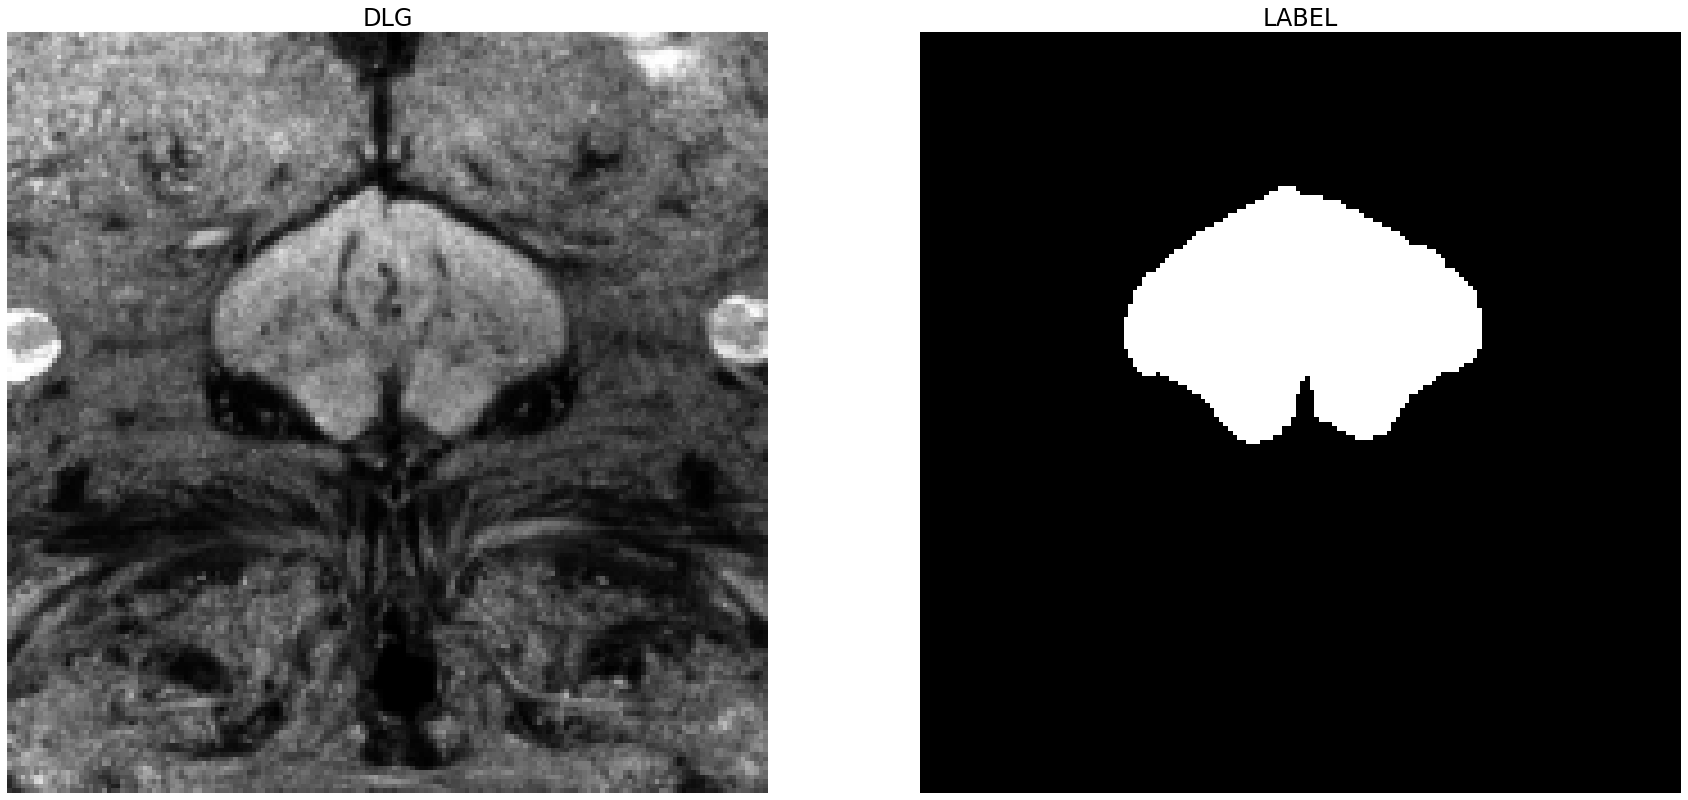

In [14]:
# ===========以上完成DLG、LABEL切割，調閱檢查============
For_training_DLG = np.load('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_DLG.npy')
For_training_LABEL = np.load('2023_18_Brain_3DUNET_DataSet/'+target_name+'_No_1_LABEL.npy')
Z_num = 50
plt.figure(figsize=(30, 60))
#目標神經元三視圖
ax = plt.subplot(1, 2, 1)
plt.imshow(For_training_DLG[Z_num],cmap = 'PuBu')
ax.set_title("DLG",fontsize=24)
plt.axis('off')
plt.gray()
# 這裡Z軸順序和標準腦相反(應該不影響)
ax = plt.subplot(1, 2, 2)
plt.imshow(For_training_LABEL[Z_num],cmap = 'PuBu')
ax.set_title("LABEL",fontsize=24)
plt.axis('off')
plt.gray()

In [15]:
# ========================已經輸出( 9x4 36)個npy檔案至 2023_18_Brain_3DUNET_DataSet 資料夾========================
# ========================將2個大腦做為測試集，移動到新資料夾，其他7個大腦做為訓練集========================
# !!!!!!!!!!!!!!!!!!!!!!!!VGlut-F-800014 & Gad1-F-400041 當作測試集合，其餘訓練集!!!!!!!!!!!!!!!!!!!!!!!!
# ========================下一步: 讀取訓練集，並生成Z軸雙向data(一共會產生56個3D腦區)，將56個3D腦區個別進行滑動切割，最終合併========================

In [16]:
# Step6_0 先將檔案移動到 2023_2_Brain_3DUNET_For_Testing and 2023_16_Brain_3DUNET_For_Training
#目的: 將 VGlut-F-800014 & Gad1-F-400041 開頭的複製到 2023_2_Brain_3DUNET_For_Testing
#      將其餘編號開頭的檔案複製到 2023_16_Brain_3DUNET_For_Training
# 讀取 2023_18_Brain_3DUNET_DataSet 資料夾中的檔案名稱
Brain_18_npy_dir = '2023_18_Brain_3DUNET_DataSet/'
# 列出所有YOLO推理輸出的圖片，只列出副檔名為png的圖片
Brain_18_npy = os.listdir(Brain_18_npy_dir)
!rm -r 2023_2_Brain_3DUNET_For_Testing
!mkdir 2023_2_Brain_3DUNET_For_Testing
!rm -r 2023_16_Brain_3DUNET_For_Training
!mkdir 2023_16_Brain_3DUNET_For_Training
# 迴圈判斷 Brain_18_npy[i] string中是否有'VGlut-F-800014' or 'Gad1-F-400041' 字串
# 如果有將 Brain_18_npy[i] 複製到 2023_2_Brain_3DUNET_For_Testing 資料夾內，若沒有則複製到 2023_16_Brain_3DUNET_For_Training
for i in range(len(Brain_18_npy)):
    if 'VGlut-F-800014' in Brain_18_npy[i] or 'Gad1-F-400041' in Brain_18_npy[i]:
        if 'original' not in Brain_18_npy[i]:
            
            shutil.copyfile(Brain_18_npy_dir + Brain_18_npy[i], '2023_2_Brain_3DUNET_For_Testing/' + Brain_18_npy[i])
    else:
        if 'original' not in Brain_18_npy[i]:
            
            shutil.copyfile(Brain_18_npy_dir + Brain_18_npy[i], '2023_16_Brain_3DUNET_For_Training/' + Brain_18_npy[i])

In [17]:
# Step6_1 讀取訓練集資料夾(目前只有7個大腦共14個DLG 14個LABEL)
# 訓練集資料夾: 2023_16_Brain_3DUNET_For_Training
# 目的:批量讀取 訓練集資料夾內的DLG 和 LABEL
# 讀取訓練集資料夾內的DLG檔案
DLG_src_files = os.listdir('2023_16_Brain_3DUNET_For_Training')
DLG_src_files = [i for i in DLG_src_files if '_DLG.npy' in i]
print('已經有Label的大腦數量: ',len(DLG_src_files))
# 讀取測試集資料夾內的LABEL檔案
LABEL_src_files = os.listdir('2023_16_Brain_3DUNET_For_Training')
LABEL_src_files = [i for i in LABEL_src_files if '_LABEL.npy' in i]
# 將兩個列表從新排列
DLG_src_files.sort()
LABEL_src_files.sort()
# 先讀取 DLG LABEL 檔案名稱

已經有Label的大腦數量:  15


In [18]:
DLG_src_files[0]

'5-HT1B-M-000008_No_1_DLG.npy'

In [19]:
LABEL_src_files[0]

'5-HT1B-M-000008_No_1_LABEL.npy'

# Step7 批次讀取單個npy檔案，訓練集需要進行Z軸雙向增強(提高資料多樣性)，再進行滑動切割，在持續新增疊加再一起
Step_of_slide = 20 # 滑動步數
Size_of_cube = 128 # 長寬尺寸
# 先處理 train_img (正方向)
for i in range(len(DLG_src_files)):
    # 批次讀取npy檔案，同時進行滑動切割
    NPY_file = np.load('2023_16_Brain_3DUNET_For_Training/'+DLG_src_files[i])
    NPY_file_patches = patchify(NPY_file, (64, Size_of_cube, Size_of_cube), step=Step_of_slide)
    #print('NPY_file_patches: ',NPY_file_patches.shape)
    # 將滑動切割後的多個cube合併
    input_NPY_file_patches = np.reshape(NPY_file_patches, (-1, NPY_file_patches.shape[3], NPY_file_patches.shape[4], NPY_file_patches.shape[5]))
    #print('input_NPY_file_patches: ',input_NPY_file_patches.shape)
    # 刪除合併前的cube 
    del NPY_file_patches
    gc.collect()  # 先觸發垃圾回收
    # 迴圈的第一次先將 input_NPY_file_patches 直接賦予給 train_img 變數
    if i ==0:
        train_img = input_NPY_file_patches
        # 刪除 input_NPY_file_patches 變數
        del input_NPY_file_patches
        gc.collect()
    else:
        train_img = np.append(train_img, input_NPY_file_patches, axis=0)
        # 刪除 input_NPY_file_patches 變數
        del input_NPY_file_patches
        gc.collect()
# 先處理 train_img (逆方向)
for i in range(len(DLG_src_files)):
    # 批次讀取npy檔案，同時進行滑動切割
    NPY_file = np.load('2023_16_Brain_3DUNET_For_Training/'+DLG_src_files[i])[::-1]# ===此行是將測試腦的Z軸順序顛倒
    NPY_file_patches = patchify(NPY_file, (64, Size_of_cube, Size_of_cube), step=Step_of_slide)
    #print('NPY_file_patches: ',NPY_file_patches.shape)
    # 將滑動切割後的多個cube合併
    input_NPY_file_patches = np.reshape(NPY_file_patches, (-1, NPY_file_patches.shape[3], NPY_file_patches.shape[4], NPY_file_patches.shape[5]))
    #print('input_NPY_file_patches: ',input_NPY_file_patches.shape)
    # 刪除合併前的cube 
    del NPY_file_patches
    gc.collect()  # 先觸發垃圾回收
    
    # 逆方向處理時因為已經已經存在 train_img，所以可以直接接續新增
    train_img = np.append(train_img, input_NPY_file_patches, axis=0)
    # 刪除 input_NPY_file_patches 變數
    del input_NPY_file_patches
    gc.collect()
# ======================================================================================
        
# 處理 train_mask(正方向)
for i in range(len(LABEL_src_files)):
    # 批次讀取npy檔案，同時進行滑動切割
    NPY_file = np.load('2023_16_Brain_3DUNET_For_Training/'+LABEL_src_files[i])
    NPY_file_patches = patchify(NPY_file, (64, Size_of_cube, Size_of_cube), step=Step_of_slide)
    #print('NPY_file_patches: ',NPY_file_patches.shape)
    # 將滑動切割後的多個cube合併
    input_NPY_file_patches = np.reshape(NPY_file_patches, (-1, NPY_file_patches.shape[3], NPY_file_patches.shape[4], NPY_file_patches.shape[5]))
    #print('input_NPY_file_patches: ',input_NPY_file_patches.shape)
    # 刪除合併前的cube 
    del NPY_file_patches
    gc.collect()  # 先觸發垃圾回收
    # 迴圈的第一次先將 input_NPY_file_patches 直接賦予給 train_img 變數
    if i ==0:
        train_mask = input_NPY_file_patches
        # 刪除 input_NPY_file_patches 變數
        del input_NPY_file_patches
        gc.collect()
    else:
        train_mask = np.append(train_mask, input_NPY_file_patches, axis=0)
        # 刪除 input_NPY_file_patches 變數
        del input_NPY_file_patches
        gc.collect()
# 處理 train_mask (逆方向)
for i in range(len(LABEL_src_files)):
    # 批次讀取npy檔案，同時進行滑動切割
    NPY_file = np.load('2023_16_Brain_3DUNET_For_Training/'+LABEL_src_files[i])[::-1]# ===此行是將測試腦的Z軸順序顛倒
    NPY_file_patches = patchify(NPY_file, (64, Size_of_cube, Size_of_cube), step=Step_of_slide)
    #print('NPY_file_patches: ',NPY_file_patches.shape)
    # 將滑動切割後的多個cube合併
    input_NPY_file_patches = np.reshape(NPY_file_patches, (-1, NPY_file_patches.shape[3], NPY_file_patches.shape[4], NPY_file_patches.shape[5]))
    #print('input_NPY_file_patches: ',input_NPY_file_patches.shape)
    # 刪除合併前的cube 
    del NPY_file_patches
    gc.collect()  # 先觸發垃圾回收
    
    # 逆方向處理時因為已經已經存在 train_img，所以可以直接接續新增
    train_mask = np.append(train_mask, input_NPY_file_patches, axis=0)
    # 刪除 input_NPY_file_patches 變數
    del input_NPY_file_patches
    gc.collect()
# ======================================================================================
# 預期DLG 和 LABEL 都有各有14組npy，進行Z軸數據增強，共有各28組3D腦區進行滑動切割，產生共36x28個cubes(1008) (1008, 64, 128, 128)

In [20]:
# 初始化存储切割后数据块的列表 ============GPT4優化
list_of_train_img_patches = []
list_of_train_mask_patches = []

Step_of_slide = 20  # 滑动窗口的步长
Size_of_cube = 128  # 切割成的小立方体的尺寸

# 处理 train_img（正向和逆向）
for i, file_name in enumerate(DLG_src_files):
    for reverse_axis in [False, True]:  # 正向和逆向
        # 读取 .npy 文件
        NPY_file_path = f'2023_16_Brain_3DUNET_For_Training/{file_name}'
        NPY_file = np.load(NPY_file_path)

        # 如果需要逆向，反转数据
        if reverse_axis:
            NPY_file = NPY_file[::-1]

        # 使用 patchify 对数据进行切割
        NPY_file_patches = patchify(NPY_file, (64, Size_of_cube, Size_of_cube), step=Step_of_slide)
        
        # 重新排列数据块以方便存储
        reshaped_patches = np.reshape(NPY_file_patches, (-1, NPY_file_patches.shape[3], NPY_file_patches.shape[4], NPY_file_patches.shape[5]))
        
        # 添加到列表
        list_of_train_img_patches.append(reshaped_patches)

# 使用 np.vstack 一次性合并所有数据块
train_img = np.vstack(list_of_train_img_patches)

# 处理 train_mask（正向和逆向）
for i, file_name in enumerate(LABEL_src_files):
    for reverse_axis in [False, True]:  # 正向和逆向
        # 读取 .npy 文件
        NPY_file_path = f'2023_16_Brain_3DUNET_For_Training/{file_name}'
        NPY_file = np.load(NPY_file_path)

        # 如果需要逆向，反转数据
        if reverse_axis:
            NPY_file = NPY_file[::-1]

        # 使用 patchify 对数据进行切割
        NPY_file_patches = patchify(NPY_file, (64, Size_of_cube, Size_of_cube), step=Step_of_slide)
        
        # 重新排列数据块以方便存储
        reshaped_patches = np.reshape(NPY_file_patches, (-1, NPY_file_patches.shape[3], NPY_file_patches.shape[4], NPY_file_patches.shape[5]))
        
        # 添加到列表
        list_of_train_mask_patches.append(reshaped_patches)

# 使用 np.vstack 一次性合并所有数据块
train_mask = np.vstack(list_of_train_mask_patches)


In [21]:
#Step8 輸出 train_img & train_mask 提供給訓練模型代碼使用
# 輸出至資料夾: 2023_3DUNET_Model_INPUT  (這個資料夾內的檔案是作為3D Unet模型的輸入來源(不區分訓練 or 測試))
# 先移除 2023_3DUNET_Model_INPUT 資料夾，再新增
!rm -r 2023_3DUNET_Model_INPUT
!mkdir 2023_3DUNET_Model_INPUT
# 輸出 train_img & train_mask
np.save('2023_3DUNET_Model_INPUT/DLG_INPUT',train_img)
np.save('2023_3DUNET_Model_INPUT/LABEL_INPUT',train_mask)

In [22]:
# ===============以上完成輸出訓練集(1008, 64, 128, 128)===============
# ===============下方開始輸出測試集(144, 64, 128, 128)===============

In [23]:
# Step9 讀取測試集資料夾(目前只有2個大腦共4個DLG 4個LABEL)
# 訓練集資料夾: 2023_2_Brain_3DUNET_For_Testing
# 目的:批量讀取 訓練集資料夾內的DLG 和 LABEL
# 讀取訓練集資料夾內的DLG檔案
DLG_src_files = os.listdir('2023_2_Brain_3DUNET_For_Testing')
DLG_src_files = [i for i in DLG_src_files if '_DLG.npy' in i]
print('已經有Label的大腦數量: ',len(DLG_src_files))
# 讀取測試集資料夾內的LABEL檔案
LABEL_src_files = os.listdir('2023_2_Brain_3DUNET_For_Testing')
LABEL_src_files = [i for i in LABEL_src_files if '_LABEL.npy' in i]
# 將兩個列表從新排列
DLG_src_files.sort()
LABEL_src_files.sort()
# 先讀取 DLG LABEL 檔案名稱

已經有Label的大腦數量:  2


In [24]:
DLG_src_files

['Gad1-F-400041_No_1_DLG.npy', 'VGlut-F-800014_No_1_DLG.npy']

In [25]:
# Step10 批次讀取單個npy檔案，測試集[不]需要進行Z軸雙向增強(提高資料多樣性)，再進行滑動切割，在持續新增疊加再一起
Step_of_slide = 20 # 滑動步數
Size_of_cube = 128 # 長寬尺寸
# 先處理 test_img (正方向)
for i in range(len(DLG_src_files)):
    # 批次讀取npy檔案，同時進行滑動切割
    NPY_file = np.load('2023_2_Brain_3DUNET_For_Testing/'+DLG_src_files[i])
    NPY_file_patches = patchify(NPY_file, (64, Size_of_cube, Size_of_cube), step=Step_of_slide)
    #print('NPY_file_patches: ',NPY_file_patches.shape)
    # 將滑動切割後的多個cube合併
    input_NPY_file_patches = np.reshape(NPY_file_patches, (-1, NPY_file_patches.shape[3], NPY_file_patches.shape[4], NPY_file_patches.shape[5]))
    #print('input_NPY_file_patches: ',input_NPY_file_patches.shape)
    # 刪除合併前的cube 
    del NPY_file_patches
    gc.collect()  # 先觸發垃圾回收
    # 迴圈的第一次先將 input_NPY_file_patches 直接賦予給 test_img 變數
    if i ==0:
        test_img = input_NPY_file_patches
        # 刪除 input_NPY_file_patches 變數
        del input_NPY_file_patches
        gc.collect()
    else:
        test_img = np.append(test_img, input_NPY_file_patches, axis=0)
        # 刪除 input_NPY_file_patches 變數
        del input_NPY_file_patches
        gc.collect()
# ======================================================================================
        
# 處理 test_mask(正方向)
for i in range(len(LABEL_src_files)):
    # 批次讀取npy檔案，同時進行滑動切割
    NPY_file = np.load('2023_2_Brain_3DUNET_For_Testing/'+LABEL_src_files[i])
    NPY_file_patches = patchify(NPY_file, (64, Size_of_cube, Size_of_cube), step=Step_of_slide)
    #print('NPY_file_patches: ',NPY_file_patches.shape)
    # 將滑動切割後的多個cube合併
    input_NPY_file_patches = np.reshape(NPY_file_patches, (-1, NPY_file_patches.shape[3], NPY_file_patches.shape[4], NPY_file_patches.shape[5]))
    #print('input_NPY_file_patches: ',input_NPY_file_patches.shape)
    # 刪除合併前的cube 
    del NPY_file_patches
    gc.collect()  # 先觸發垃圾回收
    # 迴圈的第一次先將 input_NPY_file_patches 直接賦予給 test_mask 變數
    if i ==0:
        test_mask = input_NPY_file_patches
        # 刪除 input_NPY_file_patches 變數
        del input_NPY_file_patches
        gc.collect()
    else:
        test_mask = np.append(test_mask, input_NPY_file_patches, axis=0)
        # 刪除 input_NPY_file_patches 變數
        del input_NPY_file_patches
        gc.collect()
# ======================================================================================
# 預期DLG 和 LABEL 都有各有4組npy，共有各4組3D腦區進行滑動切割，產生共36x4個cubes(144) (144, 64, 128, 128)

In [26]:
#Step11 輸出 test_img & test_mask 提供給訓練模型代碼使用
# 輸出至資料夾: 2023_3DUNET_Model_INPUT_ONLY_TEST  (這個資料夾內的檔案是作為3D Unet模型的輸入來源(不區分訓練 or 測試))
# 先移除 2023_3DUNET_Model_INPUT_ONLY_TEST 資料夾，再新增
!rm -r 2023_3DUNET_Model_INPUT_ONLY_TEST
!mkdir 2023_3DUNET_Model_INPUT_ONLY_TEST
# 輸出 train_img & train_mask
np.save('2023_3DUNET_Model_INPUT_ONLY_TEST/DLG_INPUT',test_img)
np.save('2023_3DUNET_Model_INPUT_ONLY_TEST/LABEL_INPUT',test_mask)

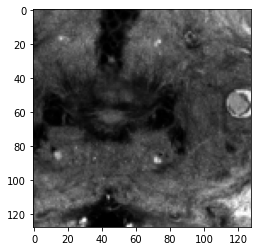

In [27]:
plt.imshow(test_img[5,35,:,:])

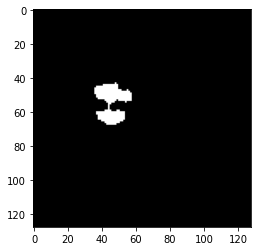

In [28]:
plt.imshow(test_mask[5,35,:,:])